<a href="https://colab.research.google.com/github/yuvalwas/MDAN-course/blob/main/MDAN_T5_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial as P
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split, RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge

Whenever we model data, we need to make the following decisions:
    
* We need to select a model (family), e.g., y is a linear function of x.
* We also have to determine a loss function, which defines what the best fit should minimize, i.e., how to choose the best model within the family of models we chose. We will use mean squared error: 
$$\text{MSE} = \frac{1}{N} \sum_i (True_i - Predicted_i)^2  $$

Considering the numerous pairs of models and loss functions available, we can employ model selection methods to determine the optimal combination. We will discuss the concept of splitting data to train and test, and we'll estimate the generalization error through cross validation.

# 1. Example polynomial fitting

Let's view a simple example for the following polynomial:

$$y = 0.5 - 0.7x  - 1.3x^2 + 1.7x^3$$

We will use polynomial regression to fit the coefficients of each power of x. This is just linear regression, with each power of x acts as a different covariate.

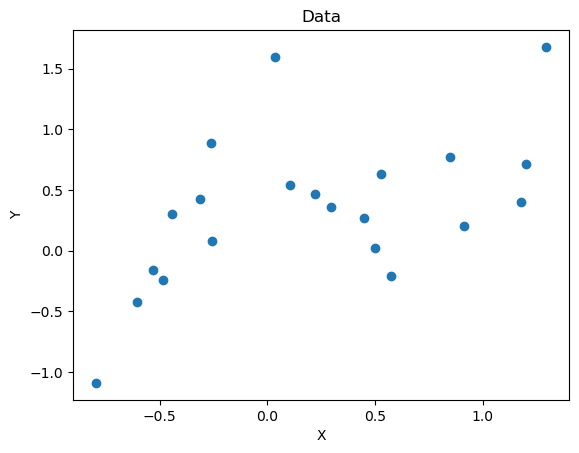

In [ ]:
# Sample 100 points of [-1,1.5]
N = 21
sigma = 0.5
np.random.seed(5)

x_data = np.random.uniform(-1, 1.5, N)
x_data.sort()

# Calculate noisy polynomial observations
true_polynomial = P.Polynomial([0.5, -0.7, -1.3, 1.7])
y_data = true_polynomial(x_data) 
y_data += np.random.normal(0, sigma, N) # Add gaussian noise to each observation

plt.scatter(x_data, y_data)
plt.xlabel("X"); plt.ylabel("Y"); plt.title("Data");
xlim = plt.xlim()
ylim = plt.ylim()


We possess a set of noisy observations. 

Now, let's utilize our model, which assumes that these observations originate from a linear model and that both the observations and their powers can be subjected to regression analysis.

Let's consider a data point, denoted as "i," which is utilized for training purposes, and we have access to its corresponding ground truth value, represented as $True_i$.

To estimate our model's preformance we will use MSE.

In [ ]:
# Raise x to different powers for power regression
def get_x_powers(x, max_power):
    return np.vstack([x**power for power in range(1, max_power+1)]).T

max_power = 5
x_data_powers = get_x_powers(x_data, max_power)

In [ ]:
def MSE(prediciton, truth): 
    return np.mean((prediciton-truth)**2)

# linear regression on the full data set
reg_naive = LinearRegression().fit(x_data_powers, y_data)
y_pred_naive = reg_naive.predict(x_data_powers)
naive_mse = MSE(y_pred_naive, y_data)
print("Naive MSE of the linear regression model: %.3f" % naive_mse)

# true polynomial MSE
true_polynomial_error = MSE(true_polynomial(x_data), y_data)
print("MSE of the true polynomial: %.3f" % true_polynomial_error)

# Split for train test
x_train, x_test, y_train, y_test = train_test_split(x_data_powers, y_data, test_size=1/3, random_state=42)
print('shapes:', x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# Linear regression
reg = LinearRegression().fit(x_train, y_train)

print('Fitted on all data polynomial coefficients:', np.concatenate(([reg_naive.intercept_], reg_naive.coef_)))
print('Fitted on test polynomial coefficients:', np.concatenate(([reg.intercept_], reg.coef_)))
print("Original polynom coeffs:", true_polynomial.coef)

y_pred = reg.predict(x_test)
reg_error = MSE(y_pred, y_test)
print("The test data MSE of the linear regression model %.3f" % reg_error)

true_polynomial_error = MSE(true_polynomial(x_test[:, 0]), y_test)
print("The test data MSE of the true polynomial %.3f" % true_polynomial_error)

Naive MSE of the linear regression model: 0.112
MSE of the true polynomial: 0.194
shapes: (14, 5) (7, 5) (14,) (7,)
Fitted on all data polynomial coefficients: [ 0.79687994 -0.05909598 -3.22200518  1.83926027  1.84529912 -0.86971064]
Fitted on test polynomial coefficients: [ 0.38831244 -0.5520093   1.44919682  3.17509255 -9.06829162  4.94047353]
Original polynom coeffs: [ 0.5 -0.7 -1.3  1.7]
The test data MSE of the linear regression model 2.688
The test data MSE of the true polynomial 0.256


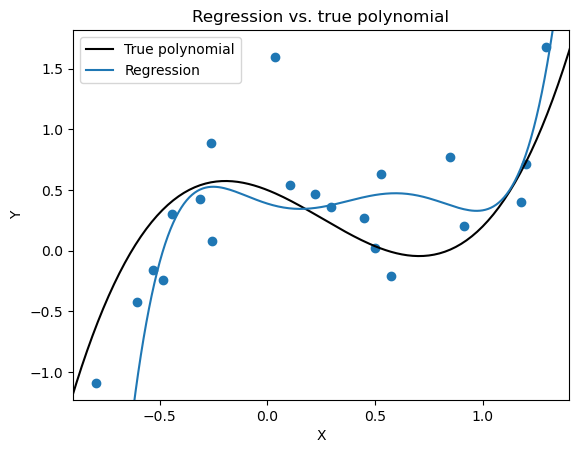

In [ ]:
#@title plot the linear regression model
x_grid = np.linspace(-1, 1.5, 201)
x_grid_powers = get_x_powers(x_grid, max_power)
plt.scatter(x_data, y_data)
plt.plot(x_grid, true_polynomial(x_grid), label='True polynomial', c="k")
plt.plot(x_grid, reg.predict(x_grid_powers), label='Regression')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Regression vs. true polynomial")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend();

# 2. Cross validation
By excluding data for validation, we end up training the model with a smaller dataset, which leads to a decrease in the amount of available data. 


However, when cross-validating we systematically partition the data into multiple subsets, training the model on some subsets, and evaluating its performance on the remaining subsets. The goal is to assess the model's generalization ability and estimate its performance on unseen data.



## 2.1 LOO


To address this, we will begin by employing the LOO (Leave One Out) method, in which one observation is left out each time.

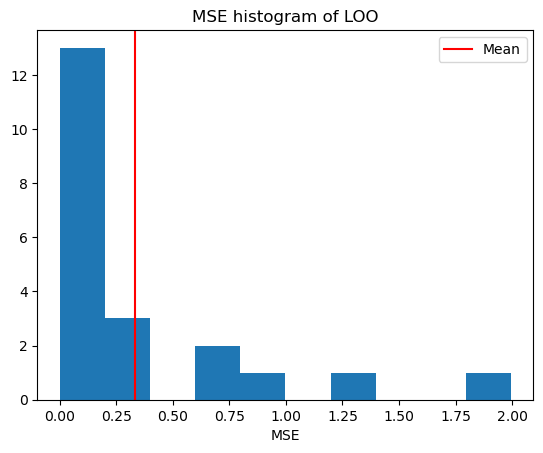

In [ ]:
loo = LeaveOneOut()
LOO_MSE_list = []

for train_index, test_index in loo.split(x_data):
    x_train, x_test = x_data_powers[train_index], x_data_powers[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    reg = LinearRegression().fit(x_train, y_train)
    mse = MSE(reg.predict(x_test), y_test)
    LOO_MSE_list.append(mse)



plt.hist(LOO_MSE_list, bins=10)
plt.axvline(np.mean(LOO_MSE_list), color='r', label='Mean')
plt.xlabel("MSE")
plt.title("MSE histogram of LOO")
plt.legend();


## 2.2 K-fold 
LOO may not always be the most effective method. Because we are testing the model as many times as the number of data points, it can be very slow. 

Let's demonstrate using K-fold cross-validation. K-fold cross-validation involves dividing the data into K equally sized subsets (folds). The model is trained K times, each time using K-1 folds as the training set and the remaining fold as the validation set. The performance of the model is then evaluated by averaging the results across the K iterations.

Compared to LOO, K-fold cross-validation provides a more reliable estimate of the model's performance as it allows for a better assessment of the generalization ability of the model by utilizing different subsets of data for training and validation. It is a widely used technique and provides a good balance between computational efficiency and accurate estimation when applying model selection.

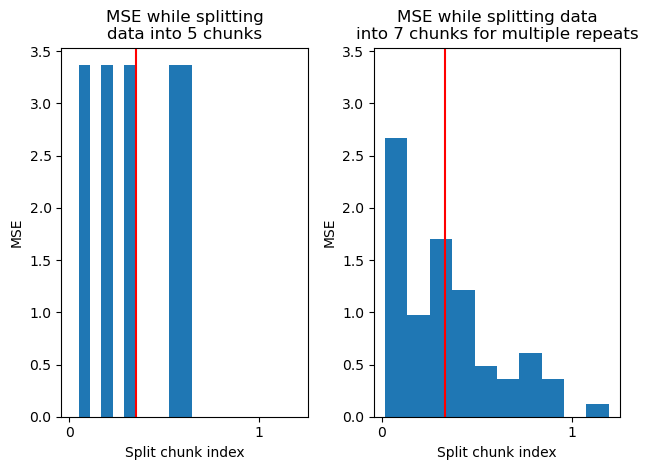

In [ ]:
kf_5_MSE_list = []
for train_index, test_index in KFold(n_splits=5, shuffle=True).split(x_data):
    x_train, x_test = x_data_powers[train_index], x_data_powers[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    reg = LinearRegression().fit(x_train, y_train)
    mse = MSE(reg.predict(x_test), y_test)
    kf_5_MSE_list.append(mse)

ax = plt.subplot(121)
plt.hist(kf_5_MSE_list, 10, density=True)
plt.axvline(np.mean(kf_5_MSE_list), color='r')
plt.xticks(range(5))
plt.xlabel("Split chunk index")
plt.ylabel("MSE")
plt.title("MSE while splitting\ndata into 5 chunks")

kf_7_MSE_list = []
for train_index, test_index in RepeatedKFold(n_splits=7, n_repeats=10).split(x_data):
    x_train, x_test = x_data_powers[train_index], x_data_powers[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    reg = LinearRegression().fit(x_train, y_train)
    mse = MSE(reg.predict(x_test), y_test)
    kf_7_MSE_list.append(mse)

plt.subplot(122, sharex=ax, sharey=ax)
plt.hist(kf_7_MSE_list, 10, density=True)
plt.axvline(np.mean(kf_7_MSE_list), color='r')
plt.xlabel("Split chunk index")
plt.ylabel("MSE")
plt.title("MSE while splitting data\ninto 7 chunks for multiple repeats")
plt.tight_layout()
plt.show()

# 3. Compare different polynomial degrees

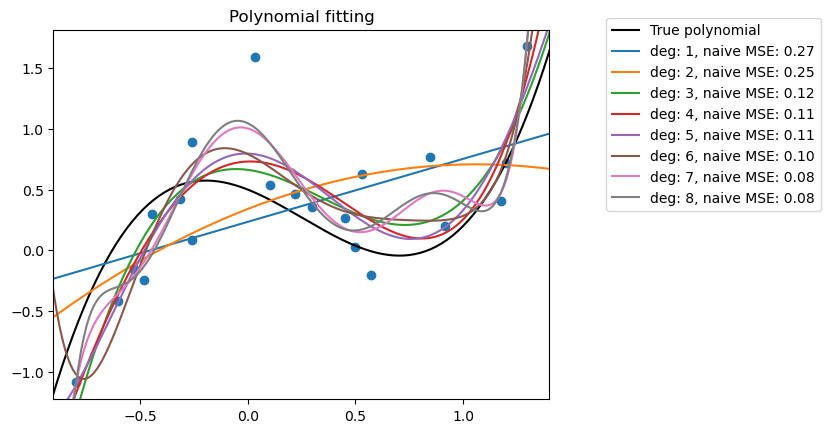

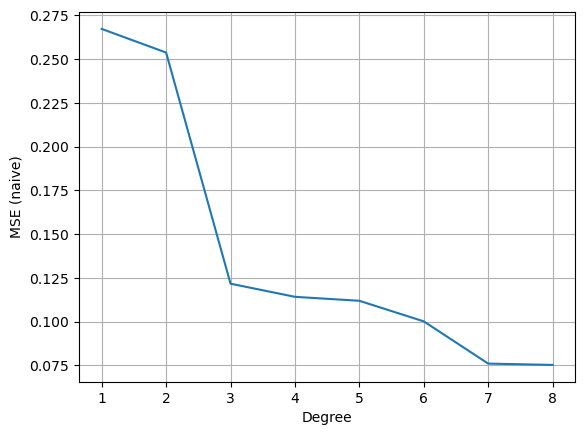

In [ ]:
MAX_POLY_DEGREE = 8
degrees = range(1, MAX_POLY_DEGREE+1)
MSE_list = [] 

plt.scatter(x_data, y_data)
plt.plot(x_grid, true_polynomial(x_grid), label='True polynomial', c="k")
plt.title("Polynomial fitting")

# Fit a polynomial function of increasing degrees
for degree in degrees:
    x_data_powers = get_x_powers(x_data, degree)
    reg = LinearRegression().fit(x_data_powers, y_data)
    mse = MSE(reg.predict(x_data_powers), y_data)
    MSE_list.append(mse)
 
    # Plot polynomial
    x_grid_powers = get_x_powers(x_grid, degree)
    plt.plot(x_grid, reg.predict(x_grid_powers),
            label=f"deg: {degree}, naive MSE: {mse:.2f}")
  
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

plt.plot(degrees, MSE_list)
plt.xlabel("Degree")
plt.ylabel("MSE (naive)")
plt.grid();

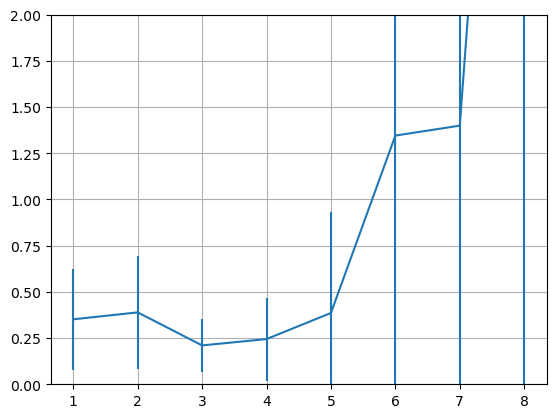

In [ ]:
MSE_mat = [] 

# Fit a polynomial function of increasing degrees
for degree in degrees:
    MSE_list = []
    x_data_powers = get_x_powers(x_data, degree)
    for train_index, test_index in RepeatedKFold(n_splits=7, n_repeats=10, random_state=3).split(x_data):
        x_train, x_test = x_data_powers[train_index], x_data_powers[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        reg = LinearRegression().fit(x_train, y_train)
        mse = MSE(reg.predict(x_test), y_test)
        MSE_list.append(mse)
    MSE_mat.append(MSE_list)
 
MSE_mat = np.array(MSE_mat)
plt.errorbar(degrees, np.mean(MSE_mat, axis=1), yerr=np.std(MSE_mat, axis=1))
plt.ylim(0, 2)
plt.grid()

# 4. Regularization

Here we penalize the size of the coefficients. Ridge regression penalizes the square of the coefficients, while lasso their absolute value.

In [ ]:
degree = 5
x_data_powers = get_x_powers(x_data, degree)
x_train, x_test, y_train, y_test = train_test_split(x_data_powers, y_data, test_size=1/3, random_state=42)

ridge_reg = Ridge(alpha=.1)
ridge_reg.fit(x_train, y_train)
np.concatenate(([ridge_reg.intercept_], ridge_reg.coef_))

array([ 0.44074834,  0.27470104, -0.80312398,  0.19227051, -0.22236185,
        0.57044369])

The MSE of the true polynomial 0.256
The MSE of a linear regression model 2.688
The MSE of a ridge regression model 0.283
The MSE of a lasso regression model 0.310


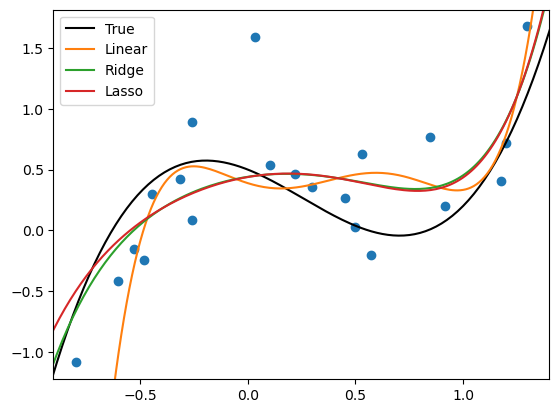

In [ ]:
print("The MSE of the true polynomial %.3f" % true_polynomial_error)
print("The MSE of a linear regression model %.3f" % reg_error)

ridge_reg_error = MSE(ridge_reg.predict(x_test), y_test)
print("The MSE of a ridge regression model %.3f" % ridge_reg_error)

lasso_reg = Lasso(alpha=0.005, max_iter=10000)
lasso_reg.fit(x_train, y_train)
lasso_reg.intercept_, lasso_reg.coef_

lasso_reg_error = MSE(lasso_reg.predict(x_test), y_test)
print("The MSE of a lasso regression model %.3f" % lasso_reg_error)

reg = LinearRegression().fit(x_train, y_train)
plt.scatter(x_data, y_data)
x_grid_powers = get_x_powers(x_grid, degree)
plt.plot(x_grid, true_polynomial(x_grid), label='True', c="k")
plt.plot(x_grid, reg.predict(x_grid_powers), label='Linear', c="C1")
plt.plot(x_grid, ridge_reg.predict(x_grid_powers), label='Ridge', c="C2")
plt.plot(x_grid, lasso_reg.predict(x_grid_powers), label='Lasso', c="C3")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend();

Let's see how the different parameters of Lasso and Ridge regression effect the resulted accuracy of the model.

We will increasingly modify the $\alpha$ value for these regressions.

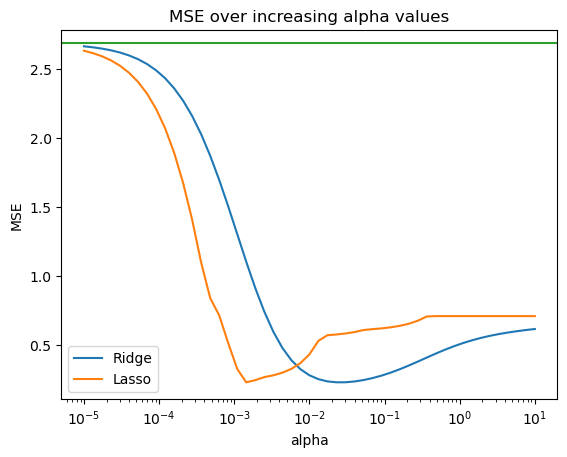

In [ ]:
alphas = np.logspace(-5, 1, 51)

errors_lasso = []
errors_ridge = []

for alpha in alphas:
    lasso_reg = Lasso(alpha=alpha, fit_intercept=True, max_iter=200000)
    lasso_reg.fit(x_train, y_train)
    errors_lasso.append(MSE(lasso_reg.predict(x_test), y_test))

    ridge_reg = Ridge(alpha=alpha, fit_intercept=True)
    ridge_reg.fit(x_train, y_train)
    errors_ridge.append(MSE(ridge_reg.predict(x_test), y_test))

plt.plot(alphas, errors_ridge, label="Ridge")
plt.plot(alphas, errors_lasso, label="Lasso")
plt.axhline(reg_error, c='C2')
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("MSE over increasing alpha values")
plt.legend();